In [1]:
# 한국어 토크나이저 다운로드를 위한 코드
!pip install -U pip
!pip install -q konlpy

# 군집화를 위한 sentence-transformer 를 위해 다운로드 
!pip install -U sentence-transformers
# 한국어 토크나이저중 mecab 사용을 위해 다운로드 
!pip install -q python-mecab-ko

# sparse-topn을 사용하기 위한 코드임 
!pip install -q /kaggle/input/sparse-dot-topn-033/sparse_dot_topn-0.3.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.2
    Uninstalling pip-23.3.2:
      Successfully uninstalled pip-23.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 3.3 MB/s eta 0:00:00 0:00:01


In [2]:
# Pretrained Tokenizer mecab 은 세팅 
from mecab import MeCab

mecab = MeCab()

def tokenizer_mecab(text):
    return mecab.morphs(text)

In [3]:
import random
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split

korean_essay = pd.read_csv('/kaggle/input/korean-essay/korean_essay.csv')[:501]
real_test_df = pd.read_csv('/kaggle/input/llm-detection-result/gpt4.csv')
display(real_test_df.head())
display(korean_essay.head())
print('실제 논술 데이터 : ',len(real_test_df))
print('korean essay : ', len(korean_essay))

/tmp/ipykernel_34/550965143.py:6: DtypeWarning: Columns (0,1,2,3,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  korean_essay = pd.read_csv('/kaggle/input/korean-essay/korean_essay.csv')[:501]


,id,Model,percent,AI Response
0,1,GPT-3.5,0,95
1,2,GPT-3.5,0,95
2,3,GPT-3.5,0,95
3,4,GPT-3.5,0,50
4,5,GPT-3.5,0,95


,ID,model,대학,제시문,중간,문제,공백,생성 Text,비고
0,NaN,GPT-3.5,2012학년도 연세대학교 논술(사회계열) 입학시험 문제,제시문 (가)\n새로운 종교를 창설하려는 여러 번의 시도가 실패로 끝난 것은 상당히...,\n,한 사회에 새로움이 부상하는 과정에서 다수가 수행하는 역할을 중심으로 제시문 (가)...,,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,NaN
1,NaN,GPT-3.5,2013학년도 연세대학교 논술(사회계열) 입학시험 문제,(가)\n가-1. \n기원전 4세기경 그리스 철학자 데모스테네스는 “자기를 속이는 ...,\n,"제시문 (가-2)를 바탕으로 제시문 (나)와 (다)를 비교 분석하시오. (1,000...",,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,NaN
2,NaN,GPT-3.5,2013학년도 연세대학교 논술(인문계열) 입학시험 문제,"제시문 (가)\n강녕의 용반, 소주의 등위, 항주의 서계는 모두 매화 산지이다.\n...",\n,"제시문 (가), (나), (다)에 공통된 주제어를 찾고, 이를 바탕으로 제시문 (가...",,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",NaN
3,NaN,GPT-3.5,2014학년도 연세대학교 수시모집 논술 (사회계열) 입학시험 문제지,제시문 (가)\n개인에 있어서의 합리적인 선택 원칙을 사회 전체에 적용할 수 있으려...,\n,개인과 사회는 서로 영향을 미칠 수 있다. 개인이 사회에 영향을 미치는 정도가 높은...,,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,NaN
4,NaN,GPT-3.5,2014학년도 연세대학교 수시모집 논술 (사회계열) 입학시험 문제지,제시문 (가)\n개인에 있어서의 합리적인 선택 원칙을 사회 전체에 적용할 수 있으려...,\n,현대 사회에서는 구성원 상호간에 서로 상충된 요구와 주장들이 늘어나고 있다. 이와 ...,,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,NaN


실제 논술 데이터 :  501
korean essay :  501


In [4]:
real_test_df['생성 Text'] = korean_essay['생성 Text']
real_test_df['generated'] = real_test_df['AI Response'].apply(lambda x: x/100)
real_test_df['label'] = real_test_df['Model'].apply(lambda x: 1 if 'gpt' in str(x).lower() else 0)
real_test_df = real_test_df[['생성 Text','label','generated']]
real_test_df = real_test_df[:501]
real_test_df.sample(10)          

,생성 Text,label,generated
107,(마)와 (바)의 차이는 공감의 측면에서 주목할 만합니다. (마)에서는 홀든의 내면...,1,0.95
356,"다모가 범한 죄인 '술 담근 죄'는 사회적, 도덕적으로 매우 심각한 문제를 초래할 ...",1,0.95
388,지문 [가]는 초콜릿회사의 ‘착한’이란 수식어에 대한 논란을 보여주고 있다. 회사 ...,0,0.80
459,"<제시문 A>와 <제시문 B>는 모두 ""규제""를 핵심으로 다루고 있지만, 그 접근 ...",1,0.95
437,제시문 [가]의 관점에서 제시문 [나]에 등장하는 ‘소녀’와 ‘신사’의 입장을 평가...,1,0.85
379,"마을 사람들은 재곤이를 사랑과 동정으로 돕고 있지만, 그의 실종(또는 죽음)을 통해...",1,0.95
369,\n제시문 [다]와 [라]에서 모두 '위태함'과 '게으름'에 대한 인식이 나타납니다...,1,0.95
417,"제시문 [다]에서는 자연과 인간의 관계를 강조하며, 자연에 대한 단순하고 소박한 접...",1,0.95
448,"제시문 [다], [라], [마]의 시각에서 제시문 [가]의 주장을 비판하고, 이에 ...",1,0.95
8,제시문 <가>와 <나>에서는 글쓰기와 지식 발전의 관계에 대해 다양한 관점을 제시하...,1,0.95


In [5]:
real_test_df.tail(10)

,생성 Text,label,generated
491,제시문 에서 놀부의 결정은 경제적 효율성과 자립을 중시하는 입장에서 일정 부분 타당...,1,0.95
492,"제시문은 텔레비전 프로그램의 국제 유통에서 경제적, 정치적, 문화적 요인이 중요한 ...",1,0.95
493,「난타」와 「명성황후」는 한국 문화의 세계화를 다루는 두 가지 사례입니다. 「난타」...,1,0.95
494,자유와 평등의 조화가 실현된 자유민주주의 사회를 이루기 위해 제시문에서는 상호간의 ...,1,0.95
495,제시문에서 '표현의 자유'는 인간의 이성을 기반으로 한 자유롭고 공개된 의견 교환을...,1,0.95
496,"오이디푸스의 결단은 제시문에서 제시된 개인과 공동체의 관계 관점 중 ③번, 즉 ""개...",1,0.95
497,[가] 요약: 제시문 [가]에서는 헤라클레이토스와 크리틸루스의 견해를 통해 시간을 ...,1,0.85
498,"[다] 요약: 제시문 [다]는 ""오늘""에 초점을 맞추고 있으며, 지나간 과거나 오지...",1,0.95
499,제시문 [마]와 [바] 요약: 제시문 [마]는 정확한 시간 측정의 필요성이 해양 항...,1,0.95
500,[가]부터 [바]까지 제시된 다양한 시간의 개념과 삶에 대한 태도는 서로 다른 문화...,1,0.95


In [6]:
import argparse
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sparse_dot_topn import awesome_cossim_topn


class TextMatcher:
    def __init__(self, ground_truth, col, topk=5, lower_bound=-1):
        self.ground_truth = ground_truth
        self.vec = TfidfVectorizer(ngram_range=(1, 2), analyzer="word",tokenizer=tokenizer_mecab,
                                   use_idf=False, min_df=2, binary=True)
        self.topk = topk
        self.lower_bound = lower_bound
        self.col = col
        
    def get_matches_df(self, sparse_matrix, texts):
        non_zeros = sparse_matrix.nonzero()

        text_indices = non_zeros[0]
        gt_indices = non_zeros[1]

        left_side = np.empty(gt_indices.size, dtype=object)
        right_side = np.empty(gt_indices.size, dtype=object)
        match_score = np.zeros(gt_indices.size)

        for index in range(gt_indices.size):
            left_side[index] = texts.values[text_indices[index]]
            right_side[index] = self.ground_truth[self.col].values[gt_indices[index]]
            match_score[index] = sparse_matrix.data[index]

        res_df = pd.DataFrame({self.col: left_side,
                               'Ground Truth': right_side,
                               'match_score': match_score})

        res_df = pd.DataFrame(texts).merge(res_df, on=self.col, how="left")
        return res_df


    def match(self, texts_to_match, n_threads=16):
        print(f"Matching {texts_to_match.shape[0]} texts to {self.ground_truth.shape[0]} texts...")
        
        X = self.vec.fit_transform(texts_to_match[self.col])
        X_gt = self.vec.transform(self.ground_truth[self.col])
        
        sparse_sim = awesome_cossim_topn(X, X_gt.T, self.topk, self.lower_bound, use_threads=True, n_jobs=n_threads)
        
        return self.get_matches_df(sparse_sim, texts_to_match[self.col])

In [7]:
#---------------------------------------------------------------------------------------------------------#

# E: Ahmet's Approach
# !python run_ahmet_approach.py \
# --score_path ./outputs/m0.parquet \
# --save_dir "./outputs" \
# --model_id "m5"

#---------------------------------------------------------------------------------------------------------#

# 우리가 볼 df -> test_df
df = real_test_df.copy()
df['prompt_id'] = 0
df['id'] = [ i for i in range(len(df))]
all_prompts = df["prompt_id"].unique()
df = df.rename(columns={'생성 Text': 'text'})
 
# HUMAN_TH = 0.1
# LLM_TH = 0.99

HUMAN_TH = 0.2
LLM_TH = 0.8

MIN_N = min(64, len(df))

df_list = []

for pid in all_prompts:
    
    # prompt id 현재 pid 인 값만 가져오기
    cdf = df[df['prompt_id']==pid].copy() 
    
    # 위에서부터 generated 값 낮은것부터 정렬해서 가져옴
    cdf = cdf.sort_values(by='generated').reset_index(drop=True)
    
    # 0.1 보다 낮거나 같으면 인간이 생성한거임 
    cdf["likely_student"] = cdf["generated"].apply(lambda x: x<=HUMAN_TH)
    
    # 0.99보다 같거나 크면 llm 이 생성한 거임 
    cdf["likely_llm"] = cdf["generated"].apply(lambda x: x>=LLM_TH)
    
    # likely_student 의 전체합이 Min_N 보다 작으면 MIN_N 행까지 likely_Student 값을 True 로 만든다.
    if cdf["likely_student"].sum() < MIN_N:
        cdf.loc[:MIN_N, "likely_student"] = True
    
    # likely llm 전체 합 값이 MIN_M보다 작으면 뒤에서부터 MIN_N까지의 likley llm 값을 True로 만든다. 
    if cdf["likely_llm"].sum() < MIN_N:
        cdf.loc[cdf.shape[0] - MIN_N:, "likely_llm"] = True
        
    display(cdf.head())
    display(cdf.tail())
    print("=="*40)
    df_list.append(cdf)

# 다합치고 generated 확률값없애는 거임 
df = pd.concat(df_list).reset_index(drop=True)
df = df.drop(columns=['generated'])

,text,label,generated,prompt_id,id,likely_student,likely_llm
0,제시문 (1)은 사회적 정당성과 이단에 대한 사회적 인식이 변화하는 것에 대해 다룬...,1,0.05,0,87,True,False
1,\n[다]의 시각은 [가]와 [나]의 상황에 대해 깊은 고찰을 제시한다. [가]에서...,1,0.05,0,139,True,False
2,제시문 [마]의 ‘퓨전’ 현상은 한 문화에 다른 문화를 의도적으로 융합하는 현상이다...,0,0.05,0,296,True,False
3,제시문 [가]의 요지제시문 [가]는 사회 복지 실현을 위해 국가의 적극적인 개입이 ...,1,0.50,0,428,True,False
4,"는 것이 필연적임을 말한다. 이는 인간이 자연의 일부이며, 그 안에서만 진정한 의미...",1,0.50,0,418,True,False


,text,label,generated,prompt_id,id,likely_student,likely_llm
496,전통적 공리주의와 규칙 공리주의는 윤리 이론에서 서로 다른 접근 방식을 제시한다....,1,0.95,0,196,False,True
497,"\n제시문 [다], [라], [마]에서는 인간과 기계, 그리고 인공지능과의 관계에...",1,0.95,0,195,False,True
498,\n제시문 [가]에서는 영화 '모던 타임스'를 통해 자본주의 사회에서의 인간 소외...,1,0.95,0,194,False,True
499,제시문 (가)에서는 허자와 실옹이 인간에 대한 각자의 시선을 나타내고 있습니다. ...,1,0.95,0,193,False,True
500,"\n【문제2】는 학생들의 문장 이해능력, 유추능력, 그리고 응용력을 동시에 측정하기...",0,0.99,0,422,False,True


In [8]:
#---------------------------------------------------------------------------------------------------------#
# MATCHING
#---------------------------------------------------------------------------------------------------------#

# 최소 64 개의 코사인 유사도를 구할거임 
TOPK = min(64, len(df))


# 인자로 score 배열 가져옴
def agg_fn(scores, margin=0.5):
    
    # 스코어 배열중 최대값 가져옴
    max_score = max(scores)
    
    #  margin 이 0.5 일시 최대값의 절반값이 된다. -> 이를 기준치라고 하자
    th = (1.0 - margin) * max_score
    
    # 기준치보다 큰수만 남긴다 이를 kept_scores 라고 한다. 
    kept_scores = [s for s in scores if s >= th]
    
    # 남겨진 수들의 평균값을 ret 라고 한다. 
    ret = np.mean(kept_scores)
    return ret

def get_match_score(df, gt_filter_col):
    # df[df[gt_filter_col]] 랑 df 는 명백히 다른거임 
    # df 는 전체데이터 즉, prompt_id 기준으로 걸러진거고 
    # df[df[gt_filter_col]] 은 llm,student 들이 잘 해결한거임 
    tm = TextMatcher(df[df[gt_filter_col]].reset_index(drop=True), "text", topk=TOPK)
    
    res_df = tm.match(df, n_threads=4)
    
    # match_score 에서 살짝 변형 시켜주고 text 기준으로 옆으로 이어붙임 
    df = res_df.groupby("text")["match_score"].agg(agg_fn).reset_index().merge(df, on="text")
    return df


sub_dfs = [get_match_score(df[df["prompt_id"] == pid], "likely_student").reset_index(drop=True)[["id", "match_score"]]
           for pid in all_prompts] # TODO: may cause exception?
sub_df = pd.concat(sub_dfs).rename(columns={"match_score": "match_score_student"})


sub_dfs = [get_match_score(df[df["prompt_id"] == pid], "likely_llm").reset_index(drop=True)[["id", "match_score"]]
           for pid in all_prompts]
sub_df2 = pd.concat(sub_dfs).rename(columns={"match_score": "match_score_llm"})

sub_df = sub_df.merge(sub_df2, on="id")

SMOOTH = 0.15

sub_df["new generated"] = -sub_df["match_score_student"] / (sub_df["match_score_llm"] + SMOOTH)
sub_df.head()
# sub_df = sub_df[["id", "generated"]].copy()

# sub_df.to_excel('output_1.xlsx',index=False)

Matching 501 texts to 65 texts...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Matching 501 texts to 475 texts...


/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,id,match_score_student,match_score_llm,new generated
0,6,0.197047,1.000000,-0.171345
1,11,0.174660,1.000000,-0.151879
2,28,0.180200,1.000000,-0.156695
3,16,0.183161,1.000000,-0.159270
4,21,1.000000,0.218707,-2.712182


In [9]:
display(sub_df.head())
display(real_test_df.head())

,id,match_score_student,match_score_llm,new generated
0,6,0.197047,1.000000,-0.171345
1,11,0.174660,1.000000,-0.151879
2,28,0.180200,1.000000,-0.156695
3,16,0.183161,1.000000,-0.159270
4,21,1.000000,0.218707,-2.712182


,생성 Text,label,generated
0,\n제시문 (가)는 역사적으로 새로운 종교를 창설하려는 시도가 실패로 끝났음에도 불...,1,0.95
1,제시문 가-2에서는 돈 키호테와 산초의 대화를 통해 현실과 환상 사이의 갈등이 나타...,1,0.95
2,"주제어로 선택된 공통 키워드는 ""아름다움""입니다.\n\n제시문 (가)에서는 매화의 ...",1,0.95
3,네 제시문들의 순서를 정하기 위해서는 각 제시문이 개인과 사회 간 영향을 어떻게 다...,1,0.50
4,네 제시문들에는 현대 사회에서의 갈등 상황에 대한 다양한 해법과 접근 방식이 내포되...,1,0.95


In [10]:
# 예시: id 열을 기준으로 두 데이터프레임을 결합합니다.
merged_df = pd.merge(sub_df, df, on="id", how="inner")
display(merged_df.head(20))

,id,match_score_student,match_score_llm,new generated,text,label,prompt_id,likely_student,likely_llm
0,6,0.197047,1.000000,-0.171345,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0,False,True
1,11,0.174660,1.000000,-0.151879,"\n(가) 제시문은 생명 복제 기술의 문제점에 대하여 논하고 있다. 인간의 고유성,...",0,0,False,True
2,28,0.180200,1.000000,-0.156695,\n(가)를 통해 '돈'은 물물교환에 있어 상품의 가치를 반영하는 매개 수단임을 알...,0,0,False,True
3,16,0.183161,1.000000,-0.159270,\n(가)에서 이름을 부르는 행위는 존재에 의미를 부여하는 행위를 가리키고 있다. ...,0,0,False,True
4,21,1.000000,0.218707,-2.712182,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0,True,False
5,280,0.195838,1.000000,-0.170294,"\n(가)와 (나)에서 나타난 문화의 형성 원리와 성격은 개인의 사회적, 경제적 환...",1,0,False,True
6,18,1.000000,0.243157,-2.543513,\n(가)의 주장은 경제적 불평등을 해소하기 위해 부의 재분배가 필요하다는 것입니다...,1,0,True,False
7,44,0.190506,1.000000,-0.165657,\n(가)의 필자는 인간의 문해력은 생득적인 것이 아닌 후천적 성취라고 주장하며 현...,0,0,False,True
8,35,1.000000,0.222196,-2.686755,\n(가)의 필자는 인간의 유아론적 경향을 서술하며 그동안 과학자들이 '감정적 자아...,0,0,True,False
9,102,0.202162,1.000000,-0.175793,"\n[가]에서 주제를 나타내는 단어는 ""역할 바꾸기""입니다. 이 단어를 사용하여 [...",1,0,False,True


In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

min_val = min(merged_df['new generated'])
max_val = max(merged_df['new generated'])

# Min-Max 스케일링 함수 정의
def min_max_scaling(x):
    return (x - min_val) / (max_val - min_val)

merged_df['real_generated']= merged_df['new generated'].apply(min_max_scaling)
# 변환된 결과 확인
display(merged_df.head(20))

,id,match_score_student,match_score_llm,new generated,text,label,prompt_id,likely_student,likely_llm,real_generated
0,6,0.197047,1.000000,-0.171345,"\n""공감""은 다른 이의 감정, 상황, 경험을 이해하고 공유하는 것을 의미합니다. ...",1,0,False,True,0.982790
1,11,0.174660,1.000000,-0.151879,"\n(가) 제시문은 생명 복제 기술의 문제점에 대하여 논하고 있다. 인간의 고유성,...",0,0,False,True,0.990161
2,28,0.180200,1.000000,-0.156695,\n(가)를 통해 '돈'은 물물교환에 있어 상품의 가치를 반영하는 매개 수단임을 알...,0,0,False,True,0.988337
3,16,0.183161,1.000000,-0.159270,\n(가)에서 이름을 부르는 행위는 존재에 의미를 부여하는 행위를 가리키고 있다. ...,0,0,False,True,0.987362
4,21,1.000000,0.218707,-2.712182,\n(가)와 (나)를 통해 알 수 있는 농업혁명의 의의는 '성공과 고통을 동시에 불...,0,0,True,False,0.020684
5,280,0.195838,1.000000,-0.170294,"\n(가)와 (나)에서 나타난 문화의 형성 원리와 성격은 개인의 사회적, 경제적 환...",1,0,False,True,0.983188
6,18,1.000000,0.243157,-2.543513,\n(가)의 주장은 경제적 불평등을 해소하기 위해 부의 재분배가 필요하다는 것입니다...,1,0,True,False,0.084552
7,44,0.190506,1.000000,-0.165657,\n(가)의 필자는 인간의 문해력은 생득적인 것이 아닌 후천적 성취라고 주장하며 현...,0,0,False,True,0.984943
8,35,1.000000,0.222196,-2.686755,\n(가)의 필자는 인간의 유아론적 경향을 서술하며 그동안 과학자들이 '감정적 자아...,0,0,True,False,0.030312
9,102,0.202162,1.000000,-0.175793,"\n[가]에서 주제를 나타내는 단어는 ""역할 바꾸기""입니다. 이 단어를 사용하여 [...",1,0,False,True,0.981106


ROC-AUC 면적: 0.4535555555555556


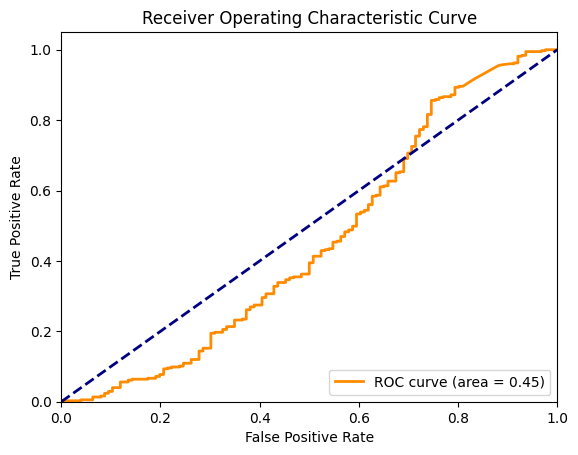

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 실제 라벨
y_true = merged_df['label'].values

# ROC 곡선 그리기
fpr, tpr, thresholds = roc_curve(y_true, merged_df['real_generated'])
roc_auc = auc(fpr, tpr)

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")

# ROC-AUC 면적 출력
print("ROC-AUC 면적:", roc_auc)

plt.show()

In [13]:
from sklearn.metrics import f1_score

# F1 스코어 계산
y_pred = [1 if score > 0.5 else 0 for score in merged_df['real_generated']]  # fixed_results는 모델 예측 결과로 가정
f1 = f1_score(y_true,  y_pred)

# F1 스코어 출력
print("F1 Score:", f1)

F1 Score: 0.8470588235294118
